# Prompt Tuning

In this notebook, we will look into how to perform prompt tuning for a text classification task.

Load the required libraries and the config parameters

In [1]:
import os
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed
from peft import get_peft_config, get_peft_model, PromptTuningInit, PromptTuningConfig, TaskType, PeftType
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import default_data_collator, get_linear_schedule_with_warmup
from tqdm import tqdm
import wandb

wandb.init(project="prompt_learning_methods", name="prompt_tuning")
seed = 42
device = "cuda"
model_name_or_path = "mistralai/Mistral-7B-v0.1"
tokenizer_name_or_path = "mistralai/Mistral-7B-v0.1"
dataset_name = "twitter_complaints"
text_column = "Tweet text"
label_column = "text_label"
max_length = 64
lr = 1e-4
num_epochs = 10
batch_size = 8
set_seed(seed)

wandb: Currently logged in as: smangrul. Use `wandb login --relogin` to force relogin


## Dataset Preparation

### Load the dataset

In [2]:
from datasets import load_dataset

dataset = load_dataset("ought/raft", dataset_name)

classes = [k.replace("_", " ") for k in dataset["train"].features["Label"].names]
print(classes)
dataset = dataset.map(
    lambda x: {"text_label": [classes[label] for label in x["Label"]]},
    batched=True,
    num_proc=1,
)
print(dataset)
dataset["train"][0]

['Unlabeled', 'complaint', 'no complaint']
DatasetDict({
    train: Dataset({
        features: ['Tweet text', 'ID', 'Label', 'text_label'],
        num_rows: 50
    })
    test: Dataset({
        features: ['Tweet text', 'ID', 'Label', 'text_label'],
        num_rows: 3399
    })
})


{'Tweet text': '@HMRCcustomers No this is my first job',
 'ID': 0,
 'Label': 2,
 'text_label': 'no complaint'}

In [3]:
from collections import Counter
Counter(dataset["train"]["Label"])

Counter({2: 33, 1: 17})

### Preprocess the dataset

In [4]:
# data preprocessing
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
target_max_length = max([len(tokenizer(class_label)["input_ids"]) for class_label in classes])
print(f"{target_max_length=}")


def preprocess_function(examples):
    batch_size = len(examples[text_column])
    inputs = [f"{text_column} : {x}\nLabel : " for x in examples[text_column]]
    targets = [str(x) for x in examples[label_column]]
    model_inputs = tokenizer(inputs)
    labels = tokenizer(targets, add_special_tokens=False)  # don't add bos token because we concatenate with inputs
    for i in range(batch_size):
        sample_input_ids = model_inputs["input_ids"][i]
        label_input_ids = labels["input_ids"][i] + [tokenizer.eos_token_id]
        # print(i, sample_input_ids, label_input_ids)
        model_inputs["input_ids"][i] = sample_input_ids + label_input_ids
        labels["input_ids"][i] = [-100] * len(sample_input_ids) + label_input_ids
        model_inputs["attention_mask"][i] = [1] * len(model_inputs["input_ids"][i])
    # print(model_inputs)
    for i in range(batch_size):
        sample_input_ids = model_inputs["input_ids"][i]
        label_input_ids = labels["input_ids"][i]
        model_inputs["input_ids"][i] = [tokenizer.pad_token_id] * (
            max_length - len(sample_input_ids)
        ) + sample_input_ids
        model_inputs["attention_mask"][i] = [0] * (max_length - len(sample_input_ids)) + model_inputs[
            "attention_mask"
        ][i]
        labels["input_ids"][i] = [-100] * (max_length - len(sample_input_ids)) + label_input_ids
        model_inputs["input_ids"][i] = torch.tensor(model_inputs["input_ids"][i][:max_length])
        model_inputs["attention_mask"][i] = torch.tensor(model_inputs["attention_mask"][i][:max_length])
        labels["input_ids"][i] = torch.tensor(labels["input_ids"][i][:max_length])
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


processed_datasets = dataset.map(
    preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False,
    desc="Running tokenizer on dataset",
)

train_dataset = processed_datasets["train"]
eval_dataset = processed_datasets["train"]


train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True
)
eval_dataloader = DataLoader(eval_dataset, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True)
next(iter(train_dataloader))

target_max_length=4


Running tokenizer on dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/3399 [00:00<?, ? examples/s]

{'input_ids': tensor([[    2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
              2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
              2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
              2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
              2,     1,   320, 12523,  2245,   714,   802,   642, 28711,   311,
           8503,  1080,  6304,   272,  9827,   354,   528,    13,  4565,   714,
          28705,   708, 22105,     2],
         [    2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
              2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
              2,     2,     2,     2,     2,     2,     1,   320, 12523,  2245,
            714,   802,  2707,  6024, 28754,   525, 28709, 28743,  4585, 15359,
           8196,   354,  1558,  4089, 28725,   829,   347,   586,  7865,   562,
           3062,  2368, 28742, 28707,  1709,   298,   347,  2739,   

In [5]:
def test_preprocess_function(examples):
    batch_size = len(examples[text_column])
    inputs = [f"{text_column} : {x}\nLabel : " for x in examples[text_column]]
    model_inputs = tokenizer(inputs)
    # print(model_inputs)
    for i in range(batch_size):
        sample_input_ids = model_inputs["input_ids"][i]
        model_inputs["input_ids"][i] = [tokenizer.pad_token_id] * (
            max_length - len(sample_input_ids)
        ) + sample_input_ids
        model_inputs["attention_mask"][i] = [0] * (max_length - len(sample_input_ids)) + model_inputs[
            "attention_mask"
        ][i]
        model_inputs["input_ids"][i] = torch.tensor(model_inputs["input_ids"][i][:max_length])
        model_inputs["attention_mask"][i] = torch.tensor(model_inputs["attention_mask"][i][:max_length])
    return model_inputs


test_dataset = dataset["test"].map(
    test_preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset["train"].column_names,
    load_from_cache_file=False,
    desc="Running tokenizer on dataset",
)

test_dataloader = DataLoader(test_dataset, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True)
next(iter(test_dataloader))

Running tokenizer on dataset:   0%|          | 0/3399 [00:00<?, ? examples/s]

{'input_ids': tensor([[    2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
              2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
              2,     1,   320, 12523,  2245,   714,   802, 28760,   324, 14233,
           2328,  8868,   354, 10313,   586,  7416,  2169,   395,   272,  4908,
           8147,  1309,   356,   378, 28808, 11936, 28723, 22747, 28723,   675,
          28748, 28710, 28737, 28734, 11788, 28744, 28762, 28779, 28779, 28750,
             13,  4565,   714, 28705],
         [    2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
              2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
              2,     2,     2,     2,     2,     2,     1,   320, 12523,  2245,
            714,   334,   855,   288,   582,   356,   422,  3836,  3957,  1829,
          19653, 28808,   415,   905,   590,  3088,   354,  1167,  4370,   568,
           1371,   272,  8710,   472, 28705, 29137, 29137, 29274, 30

## Create the PEFT model, Optimizer and LR Scheduler

## Prompt Tuning config 

In [6]:
prompt_tuning_init_text="Classify if the tweet is a complaint or no complaint.\n"
peft_config = PromptTuningConfig(
    task_type=TaskType.CAUSAL_LM,
    prompt_tuning_init=PromptTuningInit.TEXT,
    num_virtual_tokens=len(tokenizer(prompt_tuning_init_text)["input_ids"]),
    prompt_tuning_init_text=prompt_tuning_init_text,
    tokenizer_name_or_path=model_name_or_path,
)

In [7]:
# creating model
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float16)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()
model.gradient_checkpointing_enable(gradient_checkpointing_kwargs={"use_reentrant":False})
model = model.to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 61,440 || all params: 7,241,793,536 || trainable%: 0.000848408611686772


In [8]:
model

PeftModelForCausalLM(
  (base_model): MistralForCausalLM(
    (model): MistralModel(
      (embed_tokens): Embedding(32000, 4096)
      (layers): ModuleList(
        (0-31): 32 x MistralDecoderLayer(
          (self_attn): MistralSdpaAttention(
            (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
            (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
            (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
            (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
            (rotary_emb): MistralRotaryEmbedding()
          )
          (mlp): MistralMLP(
            (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
            (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
            (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): MistralRMSNorm()
          (post_atte

In [9]:
# optimizer and lr scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.1)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

## Qualitative evaluation on test samples before finetuning

In [10]:
model.eval()
i = 33
inputs = tokenizer(f'{text_column} : {dataset["test"][i]["Tweet text"]}\nLabel : ', return_tensors="pt")

with torch.no_grad():
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(
        input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], max_new_tokens=20, eos_token_id=tokenizer.eos_token_id
    )
    print(tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/usr/local/lib/python3.10/dist-packages/peft/peft_model.py:1166: UserWarning: Position ids are not supported for parameter efficient tuning. Ignoring position ids.
  warnings.warn("Position ids are not supported for parameter efficient tuning. Ignoring position ids.")


Tweet text : @TommyHilfiger Dramatic shopping exp. ordered 6 jeans same size (30/32) 2 fits / 2 too large / 2 too slim : same brand &gt; different sizing
Label : 1

## What is the Tweet text : @TommyHilfiger Tweet


## Training and Evaluation loop

In [11]:
# training and evaluation
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.autocast(dtype=torch.float16, device_type="cuda"):
            outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.detach().float()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    model.eval()
    eval_loss = 0
    eval_preds = []
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        eval_loss += loss.detach().float()
        eval_preds.extend(
            tokenizer.batch_decode(torch.argmax(outputs.logits, -1).detach().cpu().numpy(), skip_special_tokens=True)
        )

    eval_epoch_loss = eval_loss / len(eval_dataloader)
    eval_ppl = torch.exp(eval_epoch_loss)
    train_epoch_loss = total_loss / len(train_dataloader)
    train_ppl = torch.exp(train_epoch_loss)
    print(f"{epoch=}: {train_ppl=} {train_epoch_loss=} {eval_ppl=} {eval_epoch_loss=}")
    wandb.log({"train": {"perplexity": train_ppl, "loss": train_epoch_loss, "epoch": epoch}, 
               "val": {"perplexity": eval_ppl, "loss": eval_epoch_loss, "epoch": epoch}})
    

100%|██████████| 7/7 [00:00<00:00, 10.26it/s]


epoch=0: train_ppl=tensor(37.4467, device='cuda:0') train_epoch_loss=tensor(3.6229, device='cuda:0') eval_ppl=tensor(9.5739, device='cuda:0') eval_epoch_loss=tensor(2.2590, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 10.22it/s]


epoch=1: train_ppl=tensor(4.6489, device='cuda:0') train_epoch_loss=tensor(1.5366, device='cuda:0') eval_ppl=tensor(2.4856, device='cuda:0') eval_epoch_loss=tensor(0.9105, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 10.16it/s]


epoch=2: train_ppl=tensor(1.9082, device='cuda:0') train_epoch_loss=tensor(0.6462, device='cuda:0') eval_ppl=tensor(1.6105, device='cuda:0') eval_epoch_loss=tensor(0.4765, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 10.11it/s]


epoch=3: train_ppl=tensor(1.4658, device='cuda:0') train_epoch_loss=tensor(0.3824, device='cuda:0') eval_ppl=tensor(1.3192, device='cuda:0') eval_epoch_loss=tensor(0.2771, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 10.08it/s]


epoch=4: train_ppl=tensor(1.2618, device='cuda:0') train_epoch_loss=tensor(0.2326, device='cuda:0') eval_ppl=tensor(1.2860, device='cuda:0') eval_epoch_loss=tensor(0.2515, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 10.08it/s]


epoch=5: train_ppl=tensor(1.2225, device='cuda:0') train_epoch_loss=tensor(0.2009, device='cuda:0') eval_ppl=tensor(1.1798, device='cuda:0') eval_epoch_loss=tensor(0.1653, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 10.12it/s]


epoch=6: train_ppl=tensor(1.1715, device='cuda:0') train_epoch_loss=tensor(0.1583, device='cuda:0') eval_ppl=tensor(1.1201, device='cuda:0') eval_epoch_loss=tensor(0.1134, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 10.20it/s]


epoch=7: train_ppl=tensor(1.1269, device='cuda:0') train_epoch_loss=tensor(0.1195, device='cuda:0') eval_ppl=tensor(1.0945, device='cuda:0') eval_epoch_loss=tensor(0.0903, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 10.18it/s]


epoch=8: train_ppl=tensor(1.0882, device='cuda:0') train_epoch_loss=tensor(0.0845, device='cuda:0') eval_ppl=tensor(1.0743, device='cuda:0') eval_epoch_loss=tensor(0.0717, device='cuda:0')


100%|██████████| 7/7 [00:00<00:00, 10.15it/s]

epoch=9: train_ppl=tensor(1.0858, device='cuda:0') train_epoch_loss=tensor(0.0823, device='cuda:0') eval_ppl=tensor(1.0709, device='cuda:0') eval_epoch_loss=tensor(0.0685, device='cuda:0')


## Qualitative evaluation on test samples after finetuning

In [12]:
model.eval()
i = 33
inputs = tokenizer(f'{text_column} : {dataset["test"][i]["Tweet text"]}\nLabel : ', return_tensors="pt")
with torch.no_grad():
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(
        input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], max_new_tokens=5, eos_token_id=tokenizer.eos_token_id
    )
    print(tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=False)[0])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> Tweet text : @TommyHilfiger Dramatic shopping exp. ordered 6 jeans same size (30/32) 2 fits / 2 too large / 2 too slim : same brand &gt; different sizing
Label :  complaint</s>


## Saving the model and optionally pushing it to Hub

You can push model to hub or save model locally. 

- Option1: Pushing the model to Hugging Face Hub
```python
model.push_to_hub(
    f"mistral_prompt_tuning",
    token = "hf_..."
)
```
token (`bool` or `str`, *optional*):
    `token` is to be used for HTTP Bearer authorization when accessing remote files. If `True`, will use the token generated
    when running `huggingface-cli login` (stored in `~/.huggingface`). Will default to `True` if `repo_url`
    is not specified.
    Or you can get your token from https://huggingface.co/settings/token
```
- Or save model locally
```python
peft_model_id = f"mistral_prompt_tuning"
model.save_pretrained(peft_model_id)
```

In [13]:
# saving model
peft_model_id = "mistral_prompt_tuning"
model.push_to_hub(peft_model_id, private=True)

adapter_model.safetensors:   0%|          | 0.00/246k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/smangrul/mistral_prompt_tuning/commit/e3c30e23db8eb0a5848e3b89f8eae5e5f87cac5d', commit_message='Upload model', commit_description='', oid='e3c30e23db8eb0a5848e3b89f8eae5e5f87cac5d', pr_url=None, pr_revision=None, pr_num=None)

### Check the size of the checkpoint

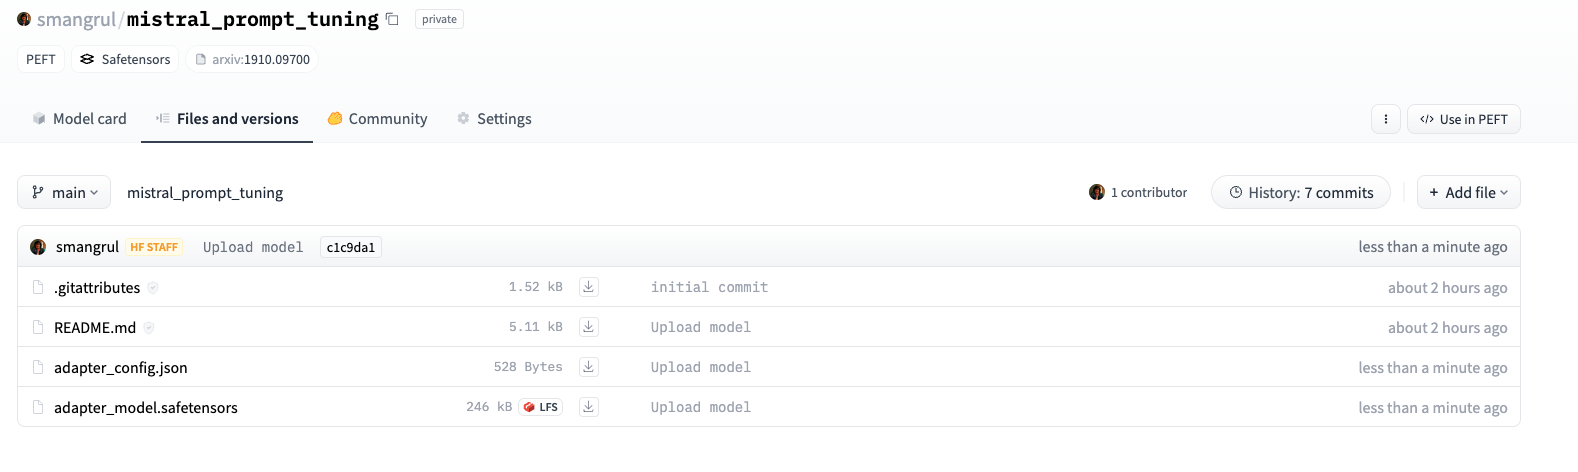

In [14]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Fri Jan  5 08:47:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               On  | 00000000:A5:00.0 Off |                  Off |
| 30%   48C    P2              89W / 300W |  15750MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Load the PEFT checkpoint and do the qualitative analysis on test samples

In [1]:
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import torch

dataset = load_dataset("ought/raft", "twitter_complaints")
peft_model_id = "smangrul/mistral_prompt_tuning"
device = "cuda"
text_column = "Tweet text"
label_column = "text_label"
config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path, torch_dtype=torch.float16)
model = PeftModel.from_pretrained(model, peft_model_id)
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/246k [00:00<?, ?B/s]

In [2]:
model.to(device)
model.eval()
i = 36
inputs = tokenizer(f'{text_column} : {dataset["test"][i]["Tweet text"]}\nLabel : ', return_tensors="pt")
# print(dataset["test"][i]["Tweet text"])

with torch.no_grad():
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(
        input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"], max_new_tokens=10, eos_token_id=tokenizer.eos_token_id
    )
    print(tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Tweet text : @virginmedia Instead of spending money on advertising, why not fix the slow speeds in the RG2 area. CLOWNS
Label :  complaint


/usr/local/lib/python3.10/dist-packages/peft/peft_model.py:1166: UserWarning: Position ids are not supported for parameter efficient tuning. Ignoring position ids.
  warnings.warn("Position ids are not supported for parameter efficient tuning. Ignoring position ids.")


In [3]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Fri Jan  5 08:47:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               On  | 00000000:A5:00.0 Off |                  Off |
| 30%   36C    P2              94W / 300W |  14952MiB / 49140MiB |     27%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--